In [1]:
import os
import anaconfig

from Preprocessing.preprocessing import load_dataframes

from utils.plotutils.plotconfig import configure_matplotlib
from utils.commonutils.cfeatures import get_unnormalised_features

from tqdm.auto import tqdm
import numpy as np
import montetracko as mt
import pandas as pd
import matplotlib.pyplot as plt
import torch

import scipy.sparse as sps


configure_matplotlib()

In [2]:
indir = "/scratch/acorreia/data/focal-loss-nopid-shared-hits/gnn_processed/test/velo-sim10b-nospillover"

In [68]:
for filename in tqdm(os.listdir(indir)[108:109]):
    path = os.path.join(indir, filename)
    batch = torch.load(path, map_location="cpu")


  0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
event_id = int(batch.event_str)
trackhandler = mt.TrackHandler.from_padded_csv(
    paths=[os.path.join("/scratch/acorreia/tracks_allen_test", f"{event_id}.csv")],
    padding_value=0,
    skip_header=True,
)
df_tracks_allen = trackhandler.dataframe

  0%|          | 0/1 [00:00<?, ?it/s]

In [70]:
_, count = np.unique(batch.edge_index.numpy(), axis=1, return_counts=True)

In [71]:
df_hits_particles = pd.read_parquet(
    batch.truncated_path + "-hits_particles.parquet",
)
df_particles = pd.read_parquet(
    batch.truncated_path + "-particles.parquet",
)


In [72]:
df_particles["long_electron"] = (
    df_particles["has_velo"] & df_particles["has_scifi"]
    & (df_particles["pid"].abs() == 11)
)

df_hits_particles = df_hits_particles.merge(
    df_particles[["particle_id", "long_electron"]],
    on="particle_id",
    how="left",
)

df_tracks_allen = df_tracks_allen.merge(
    df_hits_particles[["hit_id", "plane", "x", "y", "z"]],
    on="hit_id",
    how="left",
)

In [73]:
df_tracks_allen

event_id  track_id     hit_id  plane        x         y        z
0       476653         0  589925002     25 -19.9121  -3.57796  738.141
1       476653         0  587825303     24 -19.0176  -3.69463  688.141
2       476653         0  585725605     23 -18.0843  -3.85020  638.141
3       476653         0  583625906     22 -17.1898  -3.96687  588.141
4       476653         1  589946202     25 -25.0068  -4.93914  738.141
...        ...       ...        ...    ...      ...       ...      ...
1394    476653       191  607055758      1 -14.6424  20.78720 -263.141
1395    476653       191  537852748      0 -16.7620  23.84010 -288.141
1396    476653       192  541642640      2 -12.2895   3.57796 -236.859
1397    476653       192  673764748      1 -12.6979   3.48073 -261.859
1398    476653       192  537451658      0 -13.0284   3.30573 -286.859

[1399 rows x 7 columns]

In [74]:
batch

Data(x=[1625, 4], edge_index=[2, 5866], y=[5866], plane=[1625], un_x=[1625], un_y=[1625], un_z=[1625], truncated_path='/scratch/acorreia/data/__test__/velo-sim10b-nospillover/event000476653', event_str='000476653', y_pid=[5866], hit_id=[1625], redundance=[1625], hit_id_particle_id=[2, 1654], scores=[5866])

In [75]:
score_cut = 0.7
edge_indices = batch.edge_index[:, batch.scores > score_cut]
y =  batch.y[batch.scores > score_cut]

In [76]:
row, col = edge_indices
edge_attr = np.ones(row.size(0))
n_hits = batch.x.shape[0]
sparse_edges = sps.coo_matrix(
    (edge_attr, (row.numpy(), col.numpy())), (n_hits, n_hits)
)

In [77]:
_, candidate_labels = sps.csgraph.connected_components(
    sparse_edges, directed=False, return_labels=True
)

In [78]:
df_tracks = pd.DataFrame(
    {
        "event_id": int(batch.event_str),
        "hit_id": batch.hit_id,
        "track_id": candidate_labels,
        "plane": batch.plane
    }
)
df_tracks = df_tracks.merge(
    df_hits_particles[["hit_id", "particle_id"]],
    on="hit_id",
    how="left",
)

In [79]:
long_electron_particle_ids = df_particles[df_particles["long_electron"]]["particle_id"].to_numpy()
track_id_to_count = df_tracks[df_tracks["particle_id"].isin(long_electron_particle_ids)].groupby("track_id")["particle_id"].count()
track_ids = track_id_to_count[track_id_to_count >= 3].reset_index()["track_id"].to_numpy()

In [90]:
from matplotlib.pyplot import cm

def plot_from_track_id(
    track_id: int,
    batch,
    df_tracks: pd.DataFrame,
):
    track_hit_mask = candidate_labels == track_id
    track_edge_indices = edge_indices[:, track_hit_mask[edge_indices][0]]
    track_y = y[track_hit_mask[edge_indices][0]]
    track_un_x = batch.un_x[track_hit_mask]
    track_un_y = batch.un_y[track_hit_mask]
    track_un_z = batch.un_z[track_hit_mask]
    track_hit_ids =  batch.hit_id[candidate_labels == track_id]
    df_hit_id_particle_id = df_hits_particles[df_hits_particles["hit_id"].isin(track_hit_ids.numpy())][["hit_id", "particle_id"]]
    unique_particle_ids = df_hit_id_particle_id["particle_id"].unique().tolist()
    colors = ["b", "r", "g", "orange"]
    both_color = "k"
    hit_colors = []
    for hit_id in track_hit_ids.numpy():
        particle_ids = df_hit_id_particle_id[df_hit_id_particle_id["hit_id"] == hit_id]["particle_id"]
        if particle_ids.shape[0] > 1:
            hit_colors.append(
                both_color
            )
        else:
            hit_colors.append(colors[unique_particle_ids.index(particle_ids.iloc[0])])

    fig, axes = plt.subplots(1, 2, figsize=(8 * 2, 8))
    axes[0].set_xlabel("y")
    axes[0].set_ylabel("x")
    axes[1].set_xlabel("z")
    axes[1].set_ylabel("x")
    axes[0].scatter(
        track_un_y,
        track_un_x,
        c=hit_colors
    )
    axes[1].scatter(
        track_un_z,
        track_un_x,
        c=hit_colors
    )

    for edge, edge_y in zip(track_edge_indices.T.numpy(), track_y.numpy()):
        axes[0].plot(
            [batch.un_y[edge[0]], batch.un_y[edge[1]]],
            [batch.un_x[edge[0]], batch.un_x[edge[1]]],
            color=(
                "g" if edge_y else "r"
            )
        )
        axes[1].plot(
            [batch.un_z[edge[0]], batch.un_z[edge[1]]],
            [batch.un_x[edge[0]], batch.un_x[edge[1]]],
            color=(
                "g" if edge_y else "r"
            )
        )
    fig.suptitle("etx4velo")
    fig.tight_layout()

    # in Allen
    fig, axes = plt.subplots(1, 2, figsize=(8 * 2, 8))
    axes[0].set_xlabel("y")
    axes[0].set_ylabel("x")
    axes[1].set_xlabel("z")
    axes[1].set_ylabel("x")

    hit_ids_of_interest = np.unique(track_hit_ids)
    allen_track_ids = df_tracks_allen[df_tracks_allen["hit_id"].isin(hit_ids_of_interest)]["track_id"].unique()
    colors = cm.Accent(np.linspace(0, 1, len(allen_track_ids)))
    line_widths = np.arange(len(allen_track_ids), 0, -1) * 2
    for allen_track_id, color, lw in zip(allen_track_ids, colors, line_widths):
        track = df_tracks_allen[df_tracks_allen["track_id"] == allen_track_id].sort_values("z")
        axes[0].plot(
            track["y"],
            track["x"],
            color=color,
            marker=".",
            alpha=0.5,
            lw=lw,
        )
        axes[1].plot(
            track["z"],
            track["x"],
            color=color,
            marker=".",
            alpha=0.5,
            lw=lw,
        )

    fig.suptitle("Allen")
    fig.tight_layout()


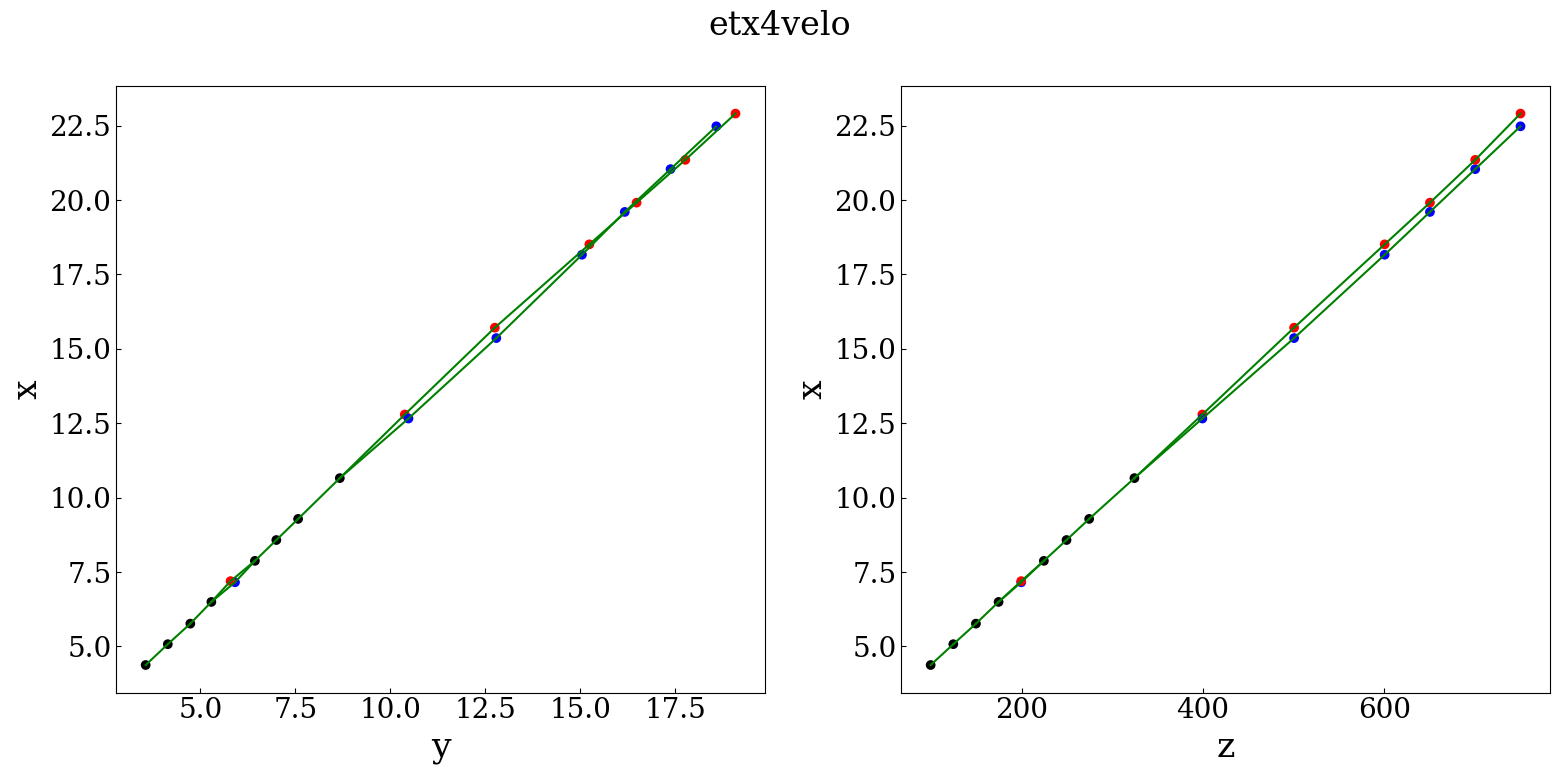

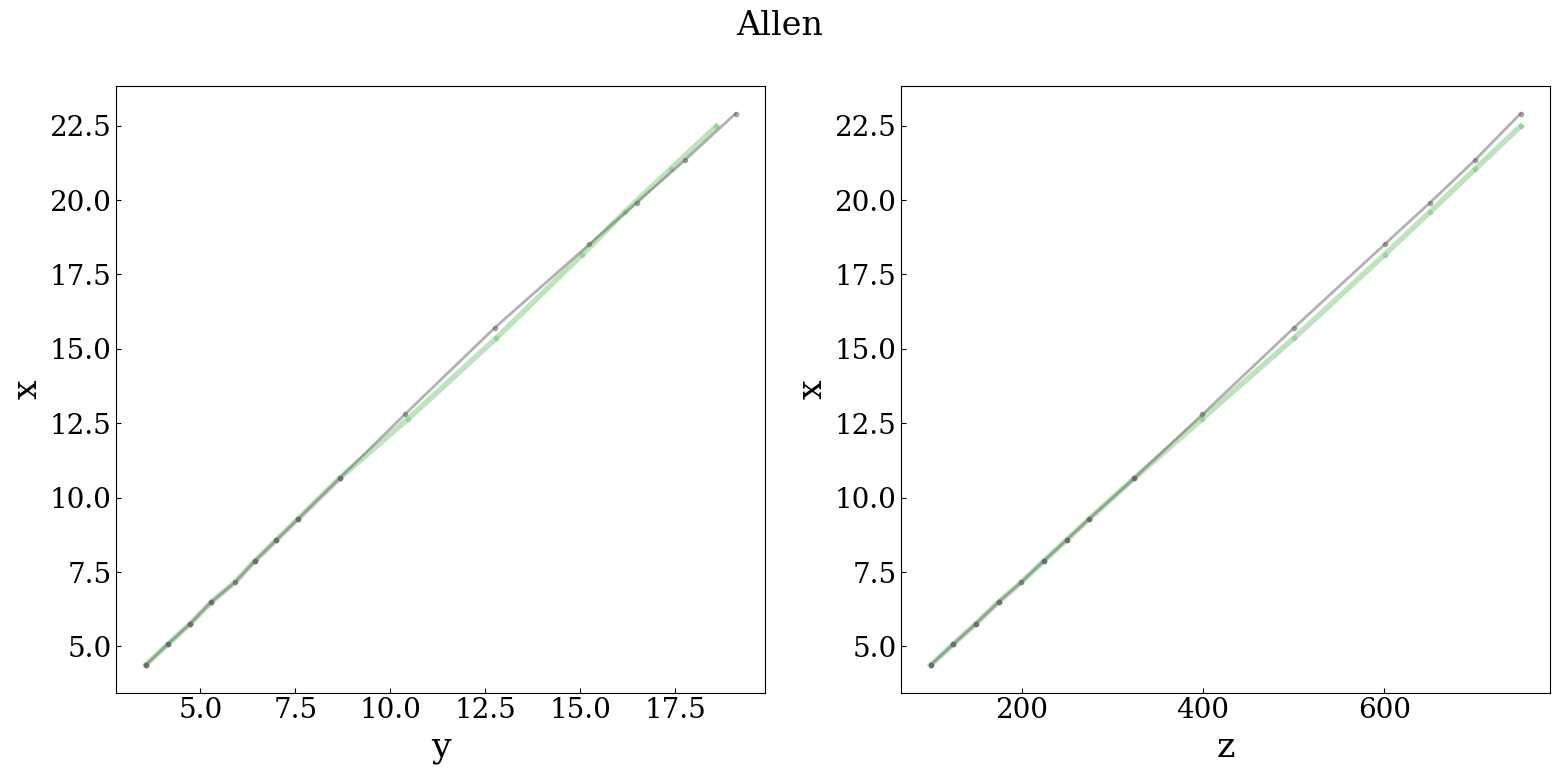

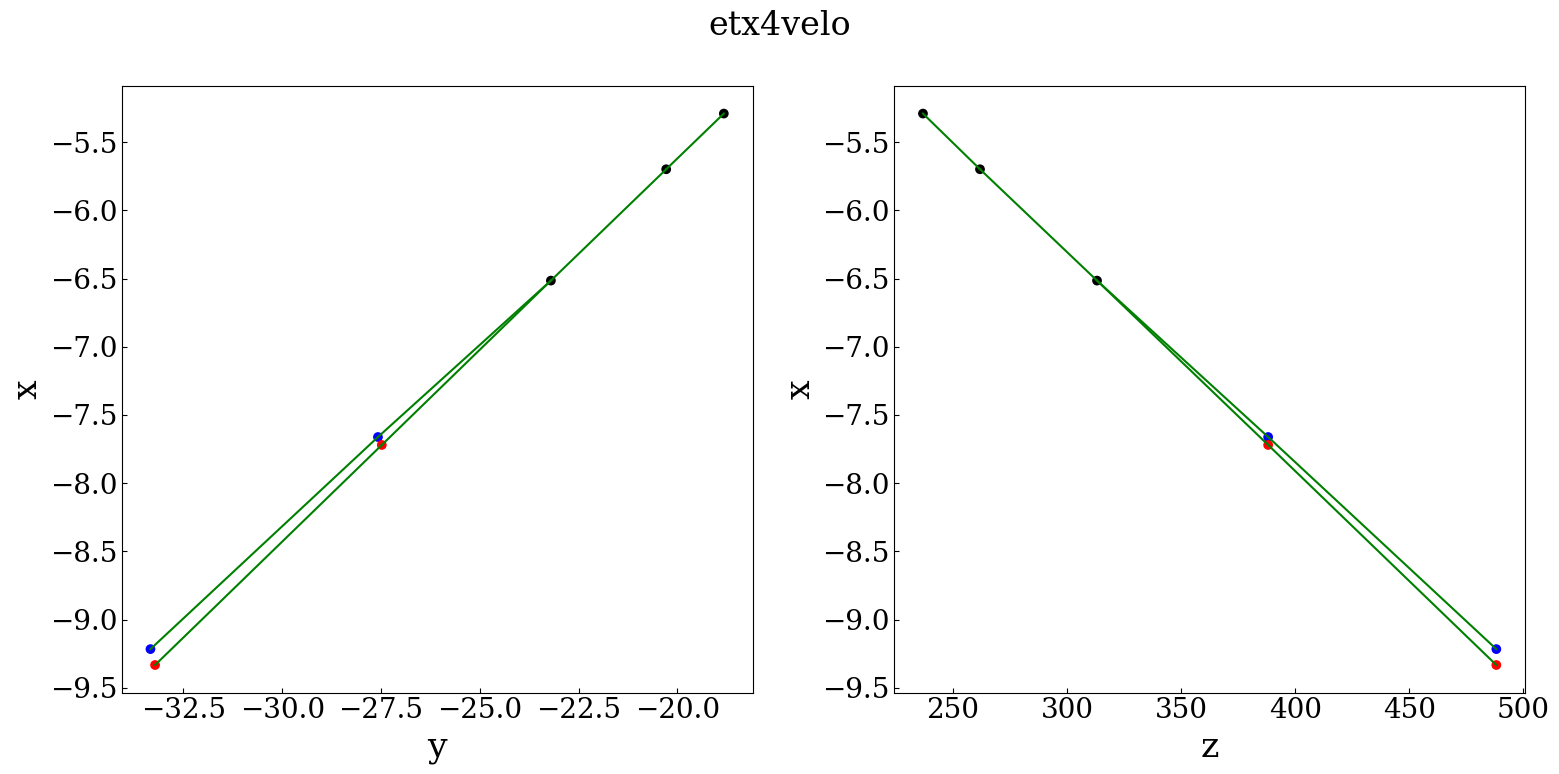

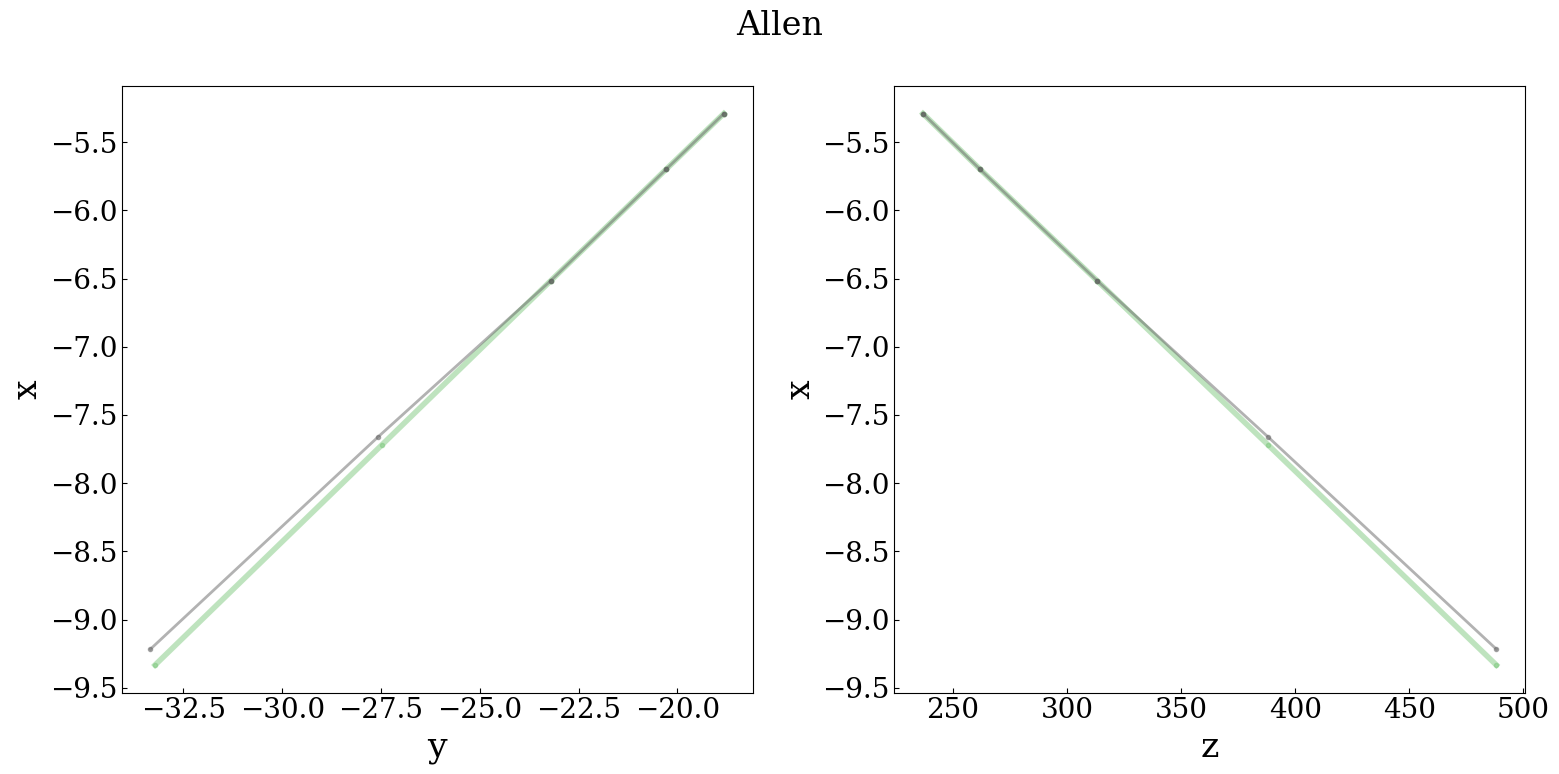

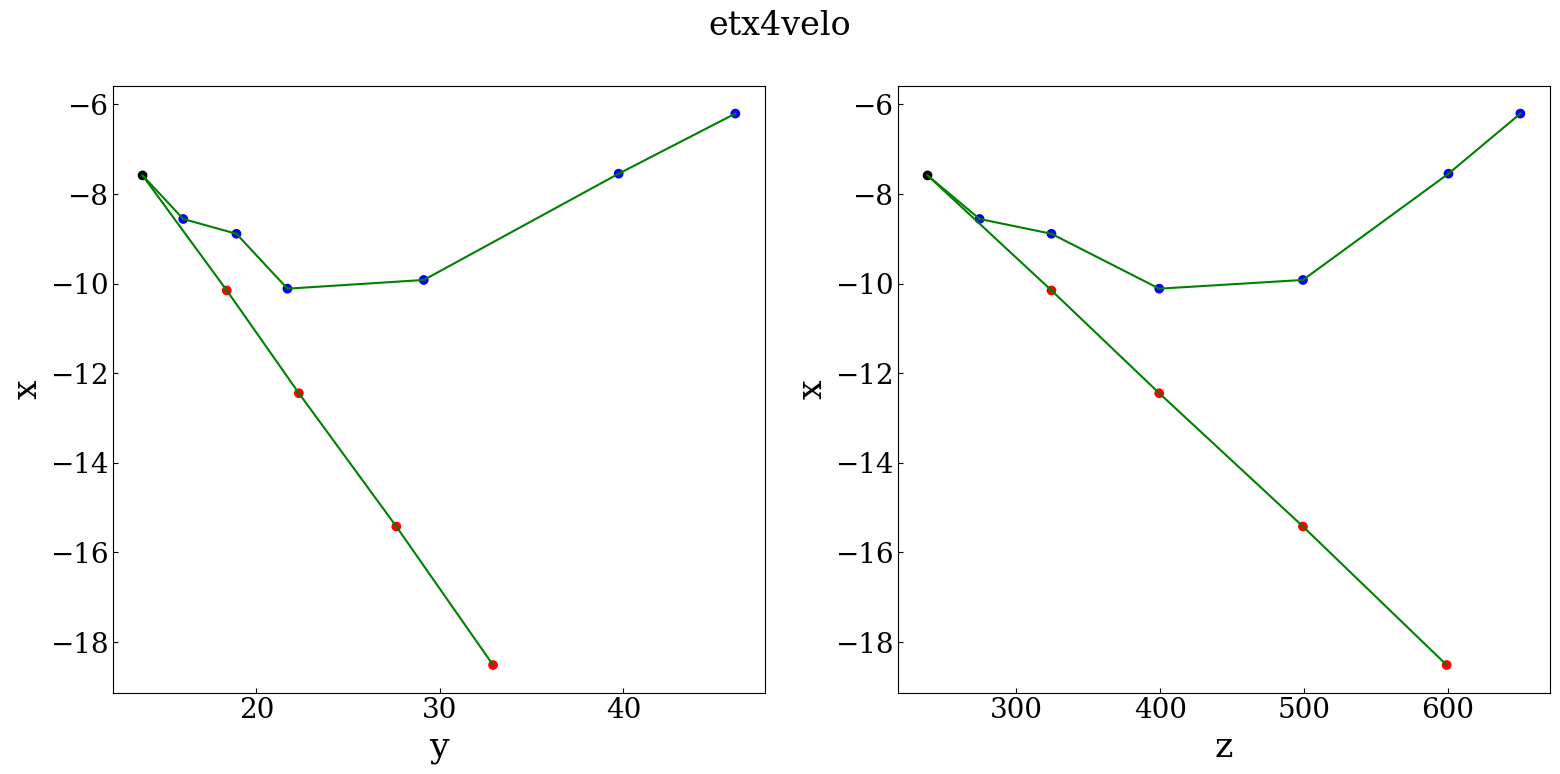

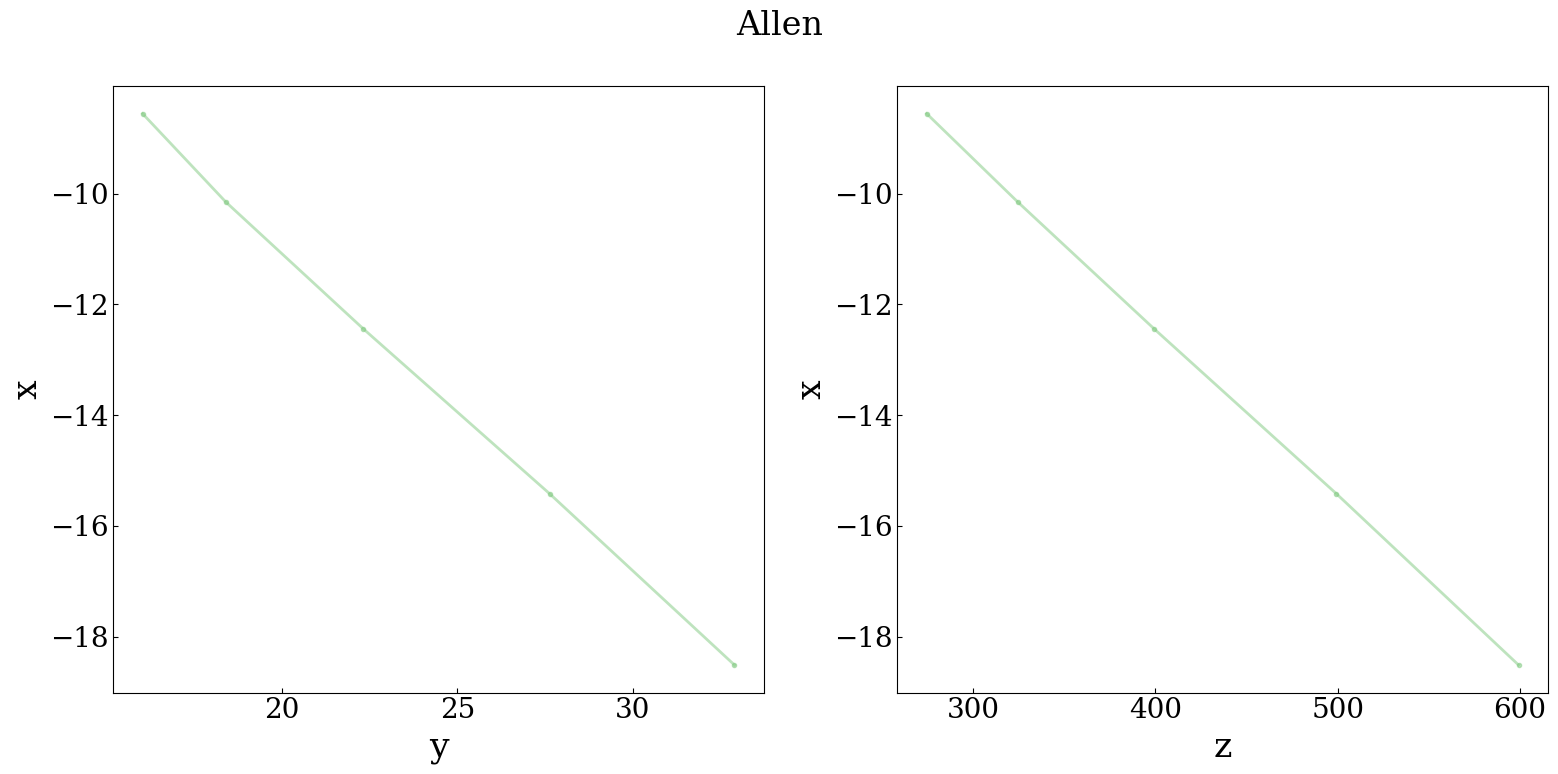

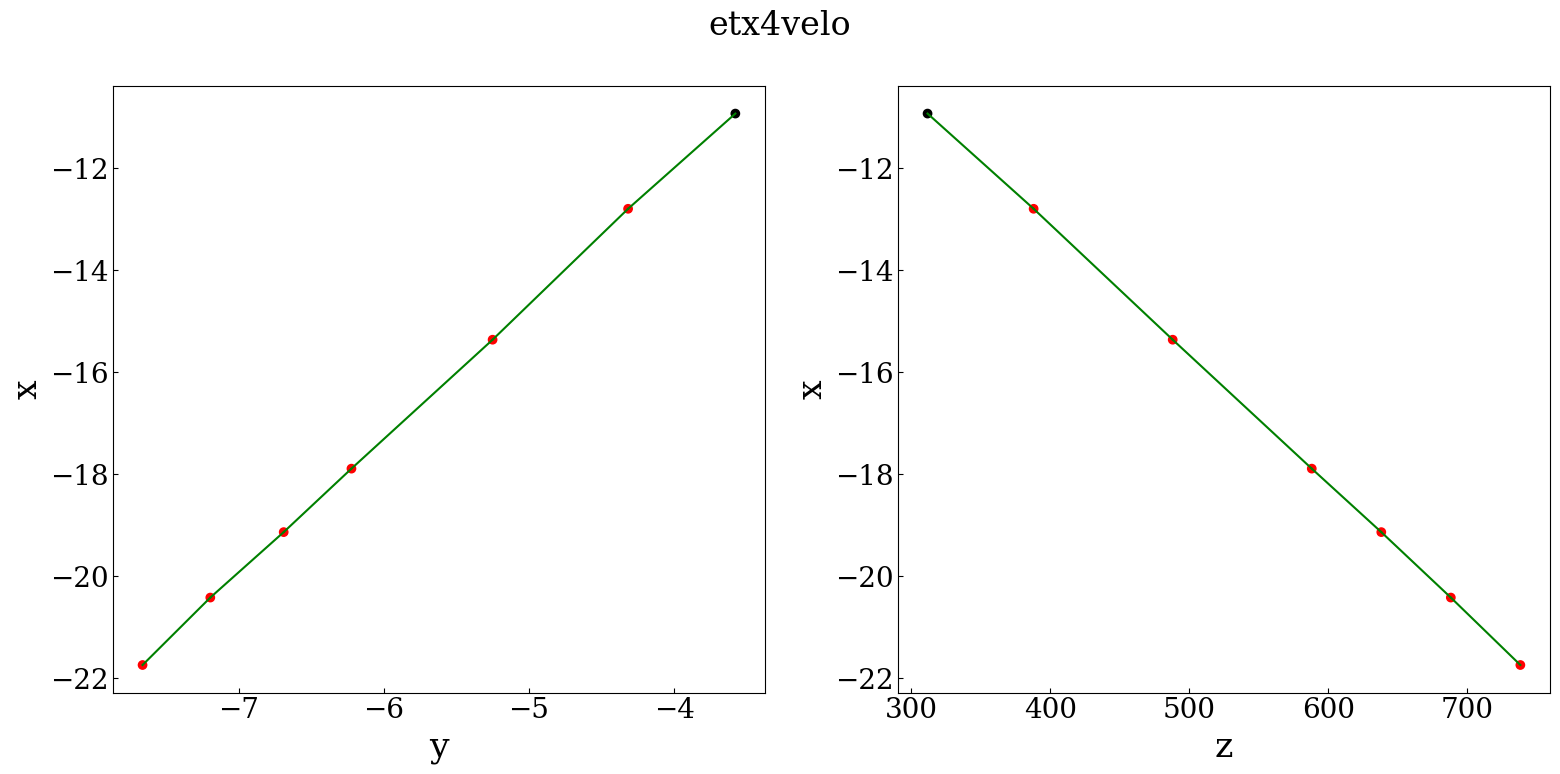

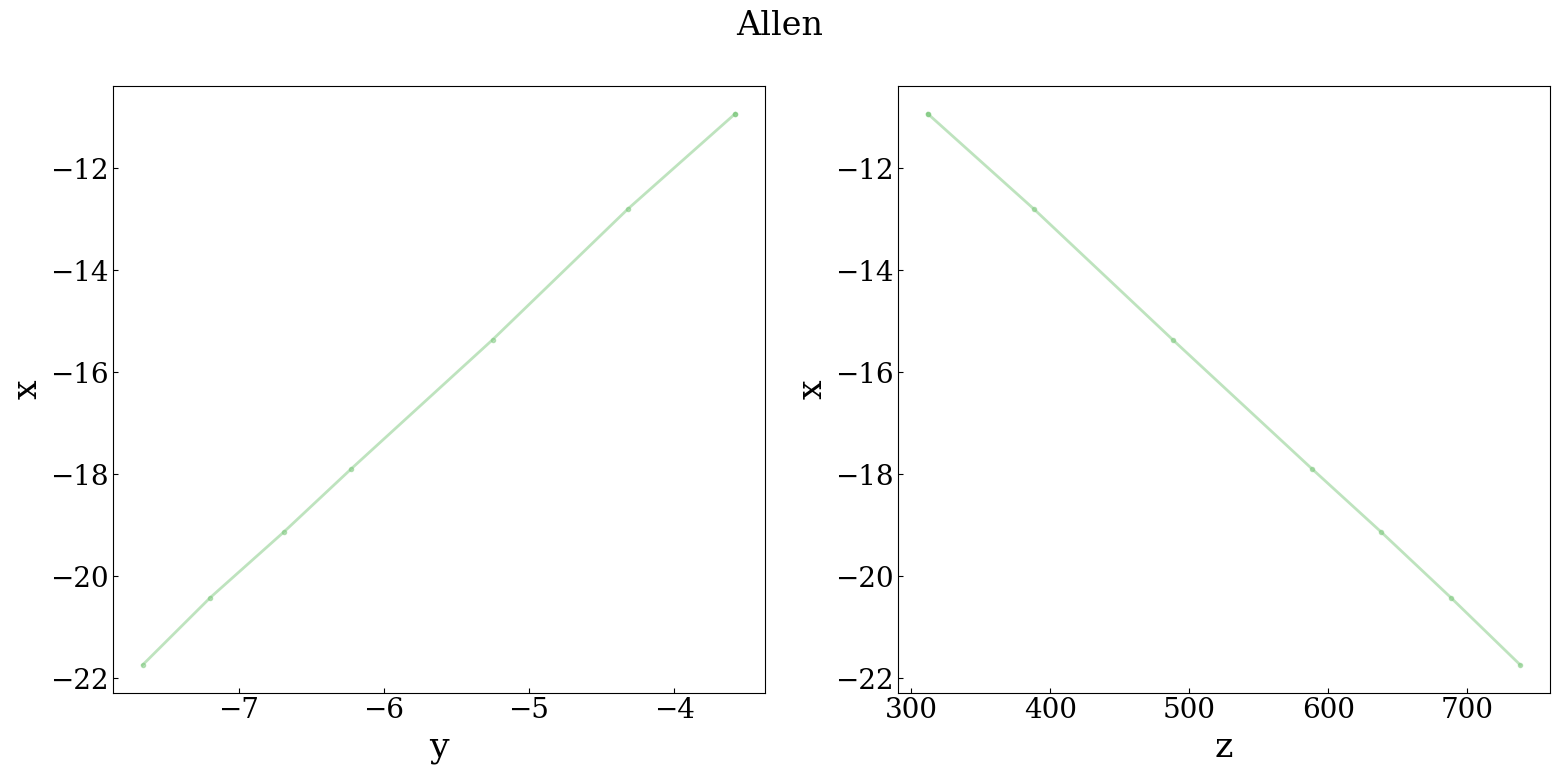

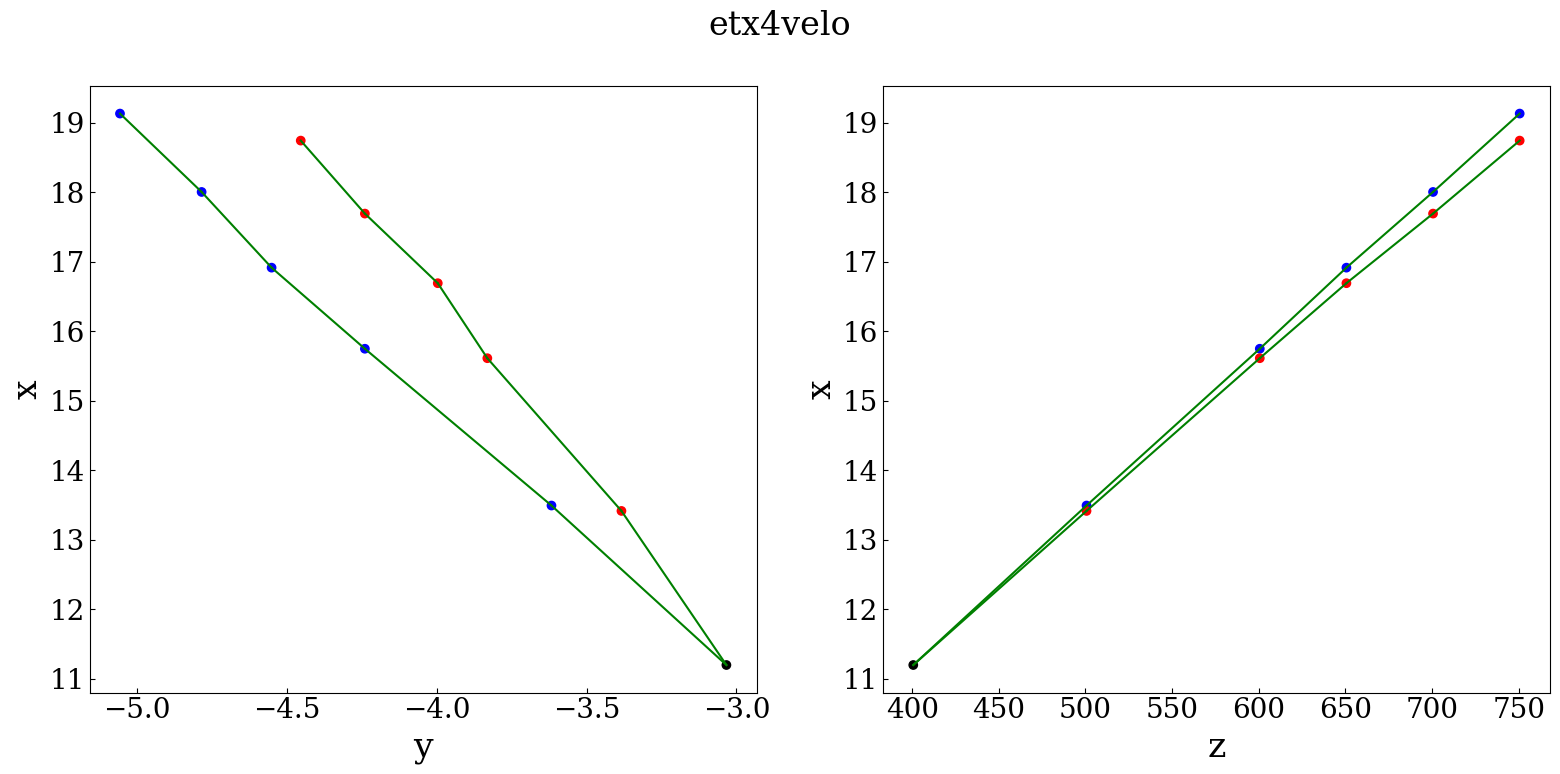

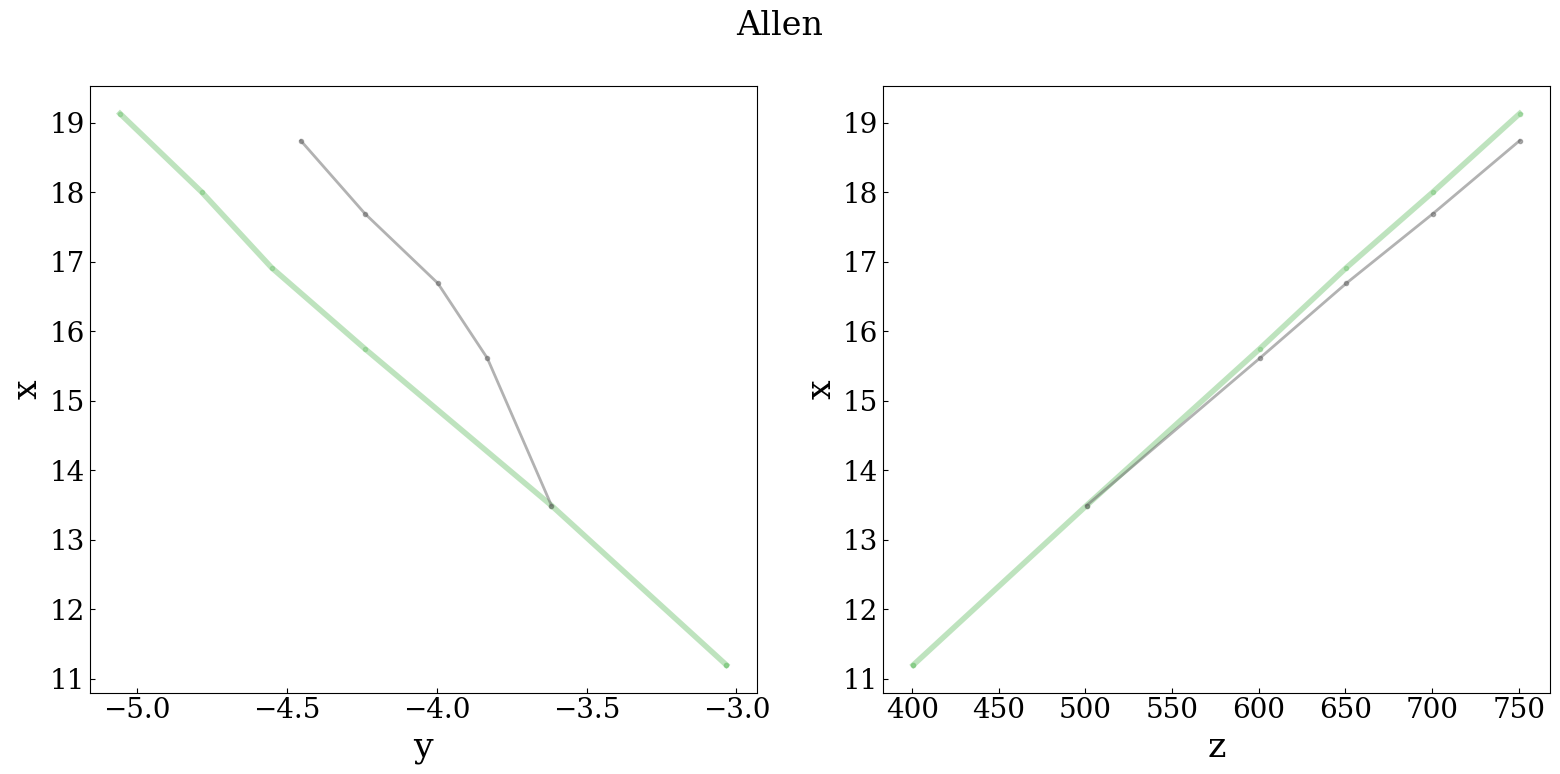

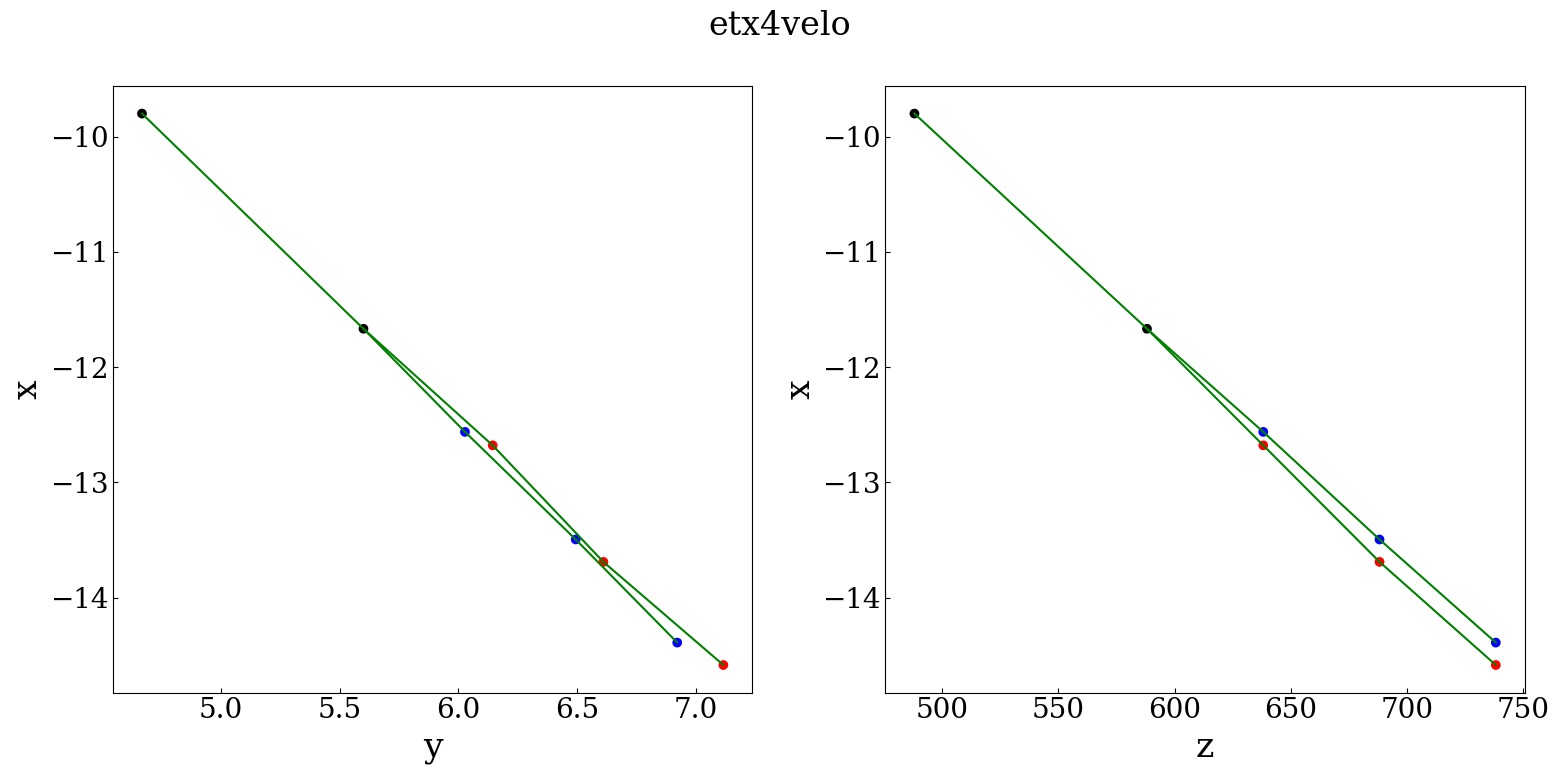

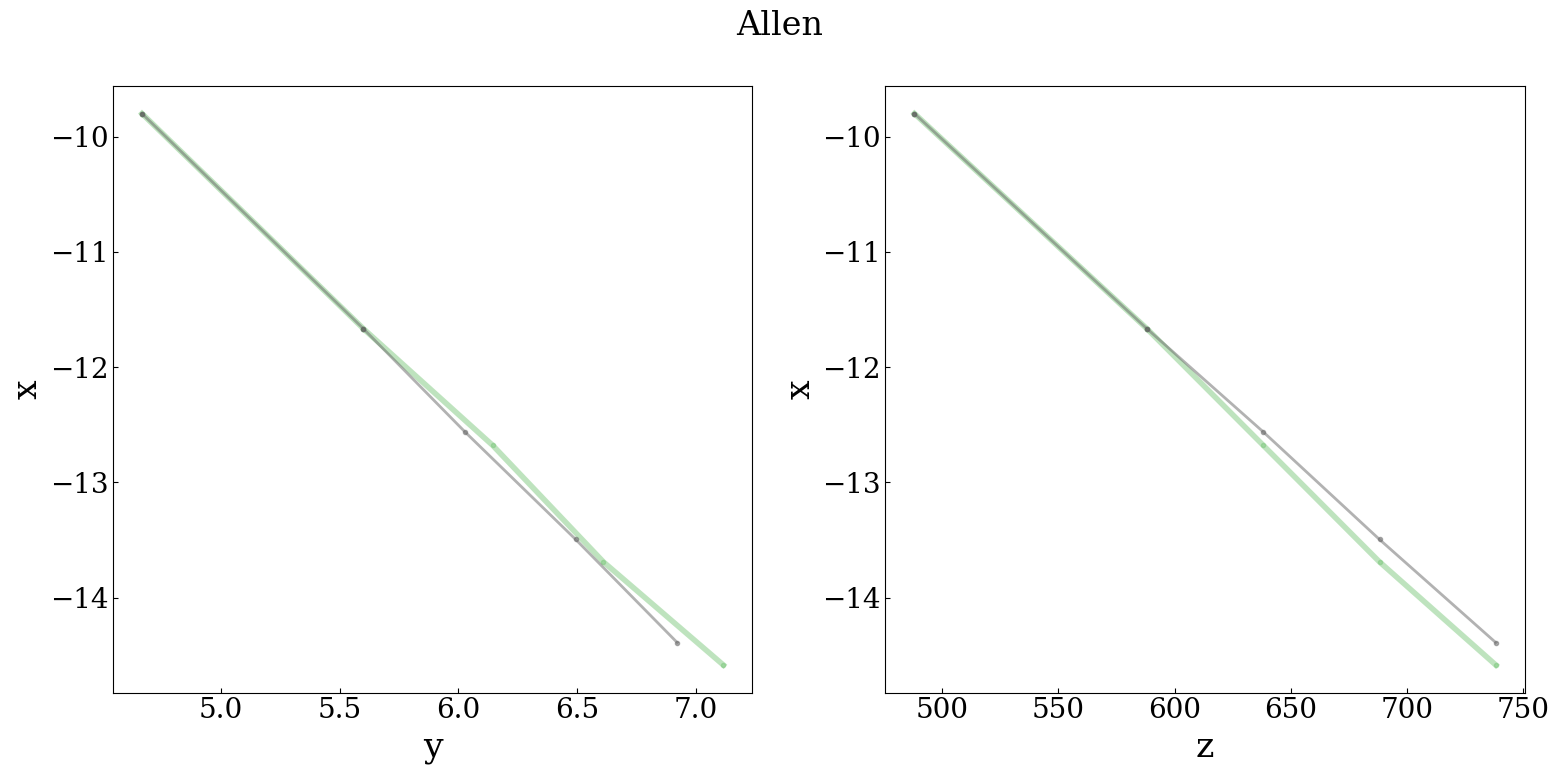

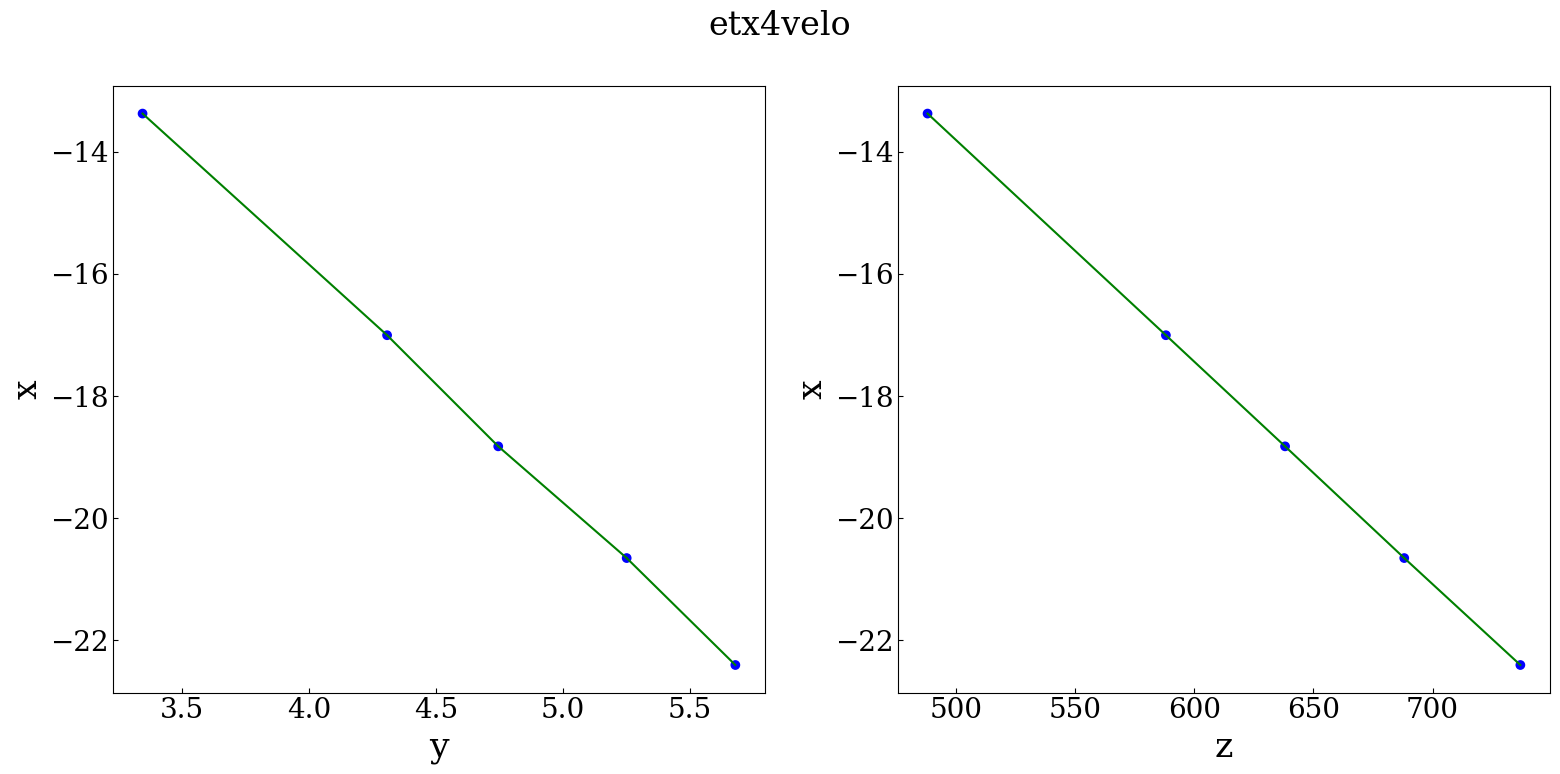

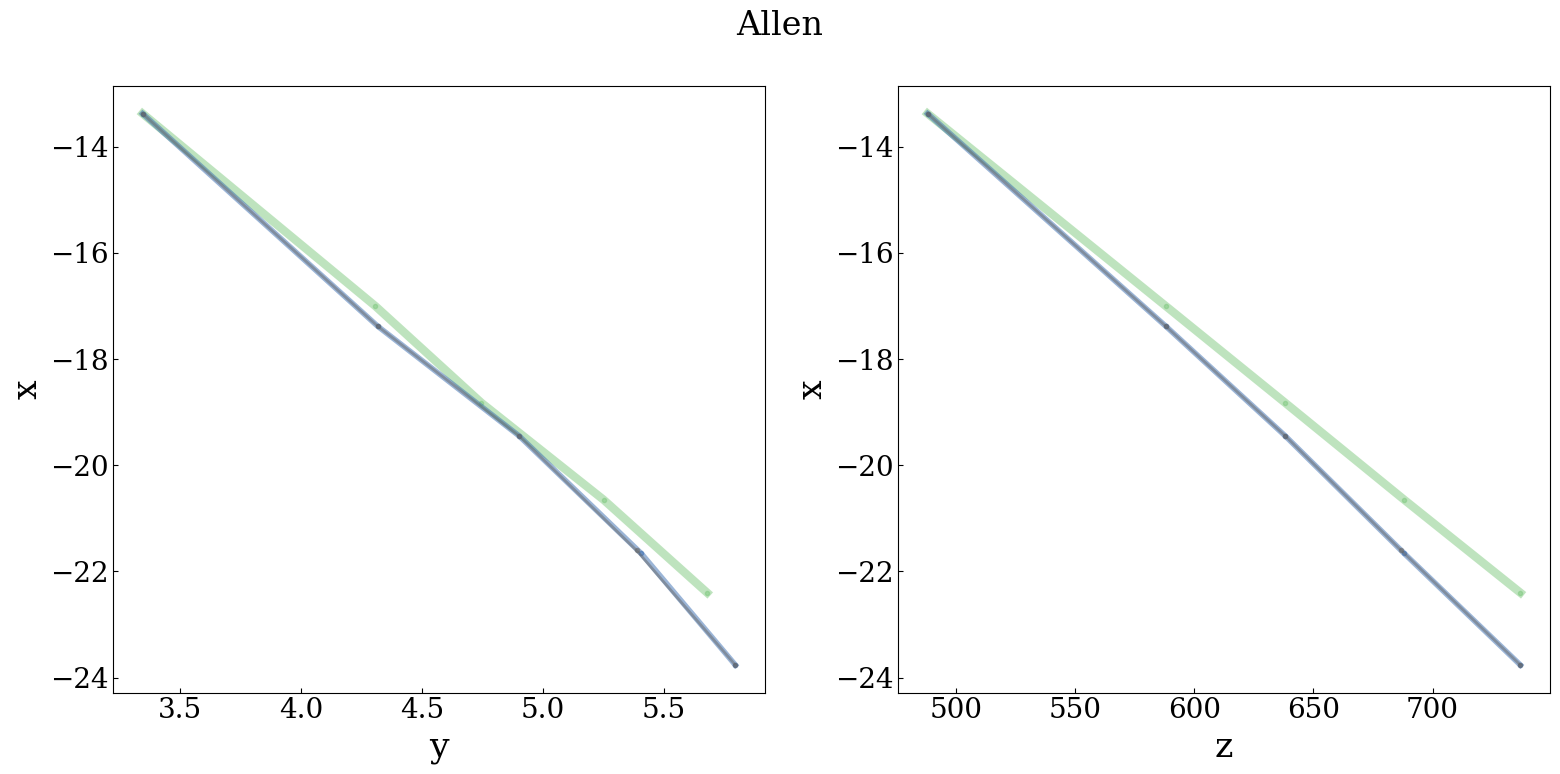

In [91]:
for annoying_track_id in track_ids[:10]:
    plot_from_track_id(annoying_track_id, batch, df_tracks)


In [ ]:
df_unchanged_tracks = df_tracks[~df_tracks["track_id"].isin(special_track_ids)]


In [ ]:
df_unchanged_tracks

In [ ]:
track_id = 309 #really_annoying_track_ids[0]

In [ ]:
list_new_df_tracks = []

In [ ]:
df_track = df_tracks[df_tracks["track_id"] == track_id]

In [75]:
df_track

event_id     hit_id  track_id  plane
640     476647  562576953       309     12
641     476647  562578232       309     12
730     476647  565101053       309     13
879     476647  569297292       309     15
951     476647  571400017       309     16
1020    476647  573494047       309     17
1022    476647  573499159       309     17
2033    476647  632211965       309     13
2054    476647  634308035       309     14
2055    476647  634310596       309     14
2077    476647  636409738       309     15
2096    476647  638504532       309     16
2731    476647  761808495       309     11

In [61]:
track_hit_mask = candidate_labels == annoying_track_id
track_edge_indices = edge_indices[:, track_hit_mask[edge_indices][0]]
min_plane = planes[track_hit_mask].min()
max_plane = planes[track_hit_mask].max()

In [58]:
def compute_angle(a, b, c):
    # Convert the points to numpy arrays
    a = np.asarray(a)
    b = np.asarray(b)
    c = np.asarray(c)

    # Calculate the vectors
    ab = b - a
    ac = c - a

    # Compute the dot product and cross product
    dot_product = np.dot(ab, ac)
    cross_product = np.linalg.norm(np.cross(ab, ac))

    # Compute the angle using the arctan2 function
    angle = np.arctan2(cross_product, dot_product)

    return angle


def get_articulations(edge_indices):
    unique_hit_ids, counts = np.unique(edge_indices, return_counts=True)
    return unique_hit_ids[counts >= 2]


articulations_left = get_articulations(track_edge_indices[0])
articulations_right = get_articulations(track_edge_indices[1])
articulations = np.unique(np.concatenate((articulations_left, articulations_right)))

In [82]:
df_track = df_tracks[df_tracks["track_id"] == track_id]

In [45]:
current_track_id = df_tracks["track_id"].max() + 1

if len(articulations) > 1:
    # Only handle start or end point
    articulations_first_plane = articulations[
        planes[articulations] == min_plane
    ]
    articulations_last_plane = articulations[
        planes[articulations] == max_plane
    ]
    articulation_first = articulations_first_plane.shape[0] != 0
    articulation_last = articulations_last_plane.shape[0] != 0

else:
    articulation = articulations[0]
    left_neighbours = track_edge_indices[0, track_edge_indices[1] == articulation]
    right_neighbours = track_edge_indices[1, track_edge_indices[0] == articulation]
    n_left_neigbhours = left_neighbours.shape[0]
    n_right_neighbours = right_neighbours.shape[0]

    if n_left_neighbours == 2 and n_right_neighbours == 2:
        angle_00 = compute_angle(left_neighbours[0], right_neighbours[0])
        angle_01 = compute_angle(left_neighbours[0], right_neighbours[1])
        angle_11 = compute_angle(left_neighbours[1], right_neighbours[1])
        arg_min_angle = np.argmin([angle_00, angle_01, angle_11])
        if arg_min_angle == 0:
            
            
    elif n_left_neighbours == 1 and n_right_neighbours == 2:
        angle_00 = compute_angle(left_neighbours[0], right_neighbours[0])
        angle_01 = compute_angle(left_neighbours[0], right_neighbours[1])
    elif n_left_neighbours == 2 and n_right_neighbours == 1:
        angle_00 = compute_angle(left_neighbours[0], right_neighbours[0])
        angle_10 = compute_angle(left_neighbours[1], right_neighbours[0])
    elif n_left_neighbours == 2 and n_right_neighbours == 0:
        
    elif n_left_neighbours == 0 and n_right_neighbours == 2:
        pass

    

[ 640 2033]
[641 730]
[ 730 2054]
[ 879 2096]
[ 951 1022]
[2033 2055]
[2054  879]
[2055 2077]
[2077  951]
[2096 1020]
[2731  640]
[2731  641]


In [83]:
df_track

event_id     hit_id  track_id  plane
640     476647  562576953       309     12
641     476647  562578232       309     12
730     476647  565101053       309     13
879     476647  569297292       309     15
951     476647  571400017       309     16
1020    476647  573494047       309     17
1022    476647  573499159       309     17
2033    476647  632211965       309     13
2054    476647  634308035       309     14
2055    476647  634310596       309     14
2077    476647  636409738       309     15
2096    476647  638504532       309     16
2731    476647  761808495       309     11

In [46]:
# Get splitting points
splitting_points = [
    node for node, degree in graph.degree()
    if degree > 2
]

# If more than 1 splitting point, just give up
# or more than 4 neighbors
# just give up
if len(splitting_points) == 1:
    splitting_point = splitting_point
    neighbours = list(graph.neighbors(splitting_point))
    if len(neighbours) <= 2:
        raise ValueError("A splitting point cannot have less than 2 neighbours")
    elif len(neighbours) <= 4:
        splitting_plane = batch.plane[splitting_point]
        neighbour_planes = planes[[neighbour_planes]]
        before_neighbours = [
            for neighbour, plane in zip(neighbours, neighbour_planes)
            if plane < splitting_plane
        ]
        after_neighbours = [
            for neighbour, plane in zip(neighbours, neighbour_planes)
            if plane > splitting_plane
        ]
        
        if len(neighbours) == 3:
            pass
        elif len(neighbours) == 4 and len(before_neighbours) == len(after_neighbours):
            pass

elif len(splitting_points) == 0:
    

SyntaxError: invalid syntax (2990774920.py, line 19)

In [55]:
articulations_right

array([], dtype=int64)

In [ ]:
list(graph.neighbors(142))

In [ ]:
nx.draw(graph, with_labels=True)